In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as jnp

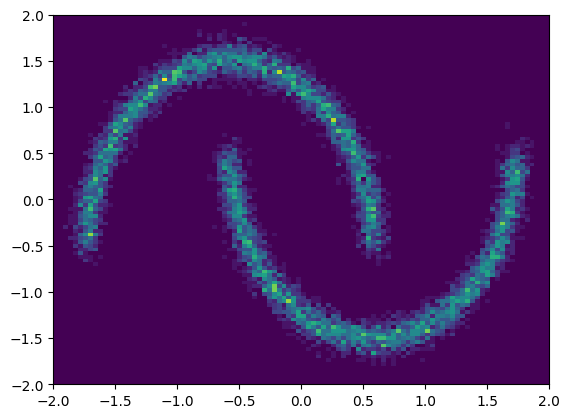

In [2]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
data, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
data = scaler.fit_transform(data)
plt.hist2d(data[:, 0], data[:, 1], bins=n_bins, range=plot_range)[-1]

In [3]:
import sys
sys.path.append('..')

import flows

from jax import grad, jit, random
from jax.example_libraries import stax, optimizers

In [4]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = data.shape[1]
num_epochs, batch_size = 300, 100

In [5]:
def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    return masks

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(jnp.tile(masks[2], 2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal(),
)

params, log_pdf, sample = init_fun(flow_rng, input_dim)

In [6]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
opt_state = opt_init(params)

In [7]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

In [8]:
def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

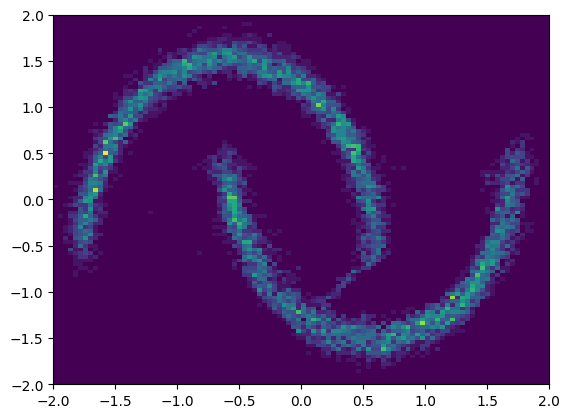

In [9]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True) # Clear plotting

    permute_rng, rng = random.split(rng)
    data = random.permutation(permute_rng, data)
    for batch_index in range(0, len(data), batch_size):
        opt_state = step(next(itercount), opt_state, data[batch_index:batch_index+batch_size])
     
    params = get_params(opt_state)
    sample_rng, rng = random.split(rng)
    X_syn = sample(rng, params, data.shape[0])
    
    plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
    plt.show()
params = get_params(opt_state)

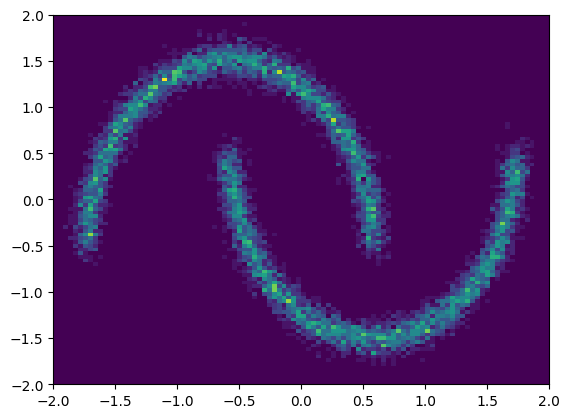

In [10]:
plt.hist2d(data[:, 0], data[:, 1], bins=n_bins, range=plot_range)[-1]